In [1]:
import sklearn
import csv
import cv2
import os
import numpy as np
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from sklearn.model_selection import train_test_split
from os import getcwd
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, Callback
from sklearn.utils import shuffle
print("done")

Using TensorFlow backend.


done


## Preprocess image function (distortion, color space conversion)

1. Crop the image to keep pixels 50-140 on the y axis while retaining the x axis and the 3(bgr) layers
2. Resize the image to minimize the required memory and make the training faster, the target resize is the recommended amount from the Nvidia documentation
3. Apply a small gaussian blur to reduce noise
4. Convert the image to YUV color space to better the contrast for the learning process. As the Nvidia doc suggests, the YUV will allow the model to learn view the contrasting terrains/edges better.

In [2]:
def preprocess_image(img):
    #avoid input size error in keras model
    new_img = img[50:140,:,:]
    new_img = cv2.GaussianBlur(new_img, (3,3), 0)
    new_img = cv2.resize(new_img,(200, 66), interpolation = cv2.INTER_AREA)
    new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2YUV)
    return new_img

print("Done")

Done


## Generate the training data with pre processing

### The Generator
This generator is used to create extra training data by applying changes to the current images and adding them as new data.
The first change is to make sure the images match our pre processing from the drive.py so we call pre_process() on each of them.
Next we shuffle the data and if the angle size is greater or less than .33 we create a mirrored image and apply the opposite(to the original) angle and append that data to the data set. We then shuffle the data again before yielding the batch size back.

In [3]:
def generate_training_data(image_paths, angles, batch_size=128):
    image_paths, angles = shuffle(image_paths, angles)
    X,y = ([],[])
    while True:       
        for i in range(len(angles)):
            img = cv2.imread(image_paths[i])
            angle = angles[i]
            img = preprocess_image(img)
            X.append(img)
            y.append(angle)
            if len(X) == batch_size:
                yield (np.array(X), np.array(y))
                X, y = ([],[])
                image_paths, angles = shuffle(image_paths, angles)
            # flip horizontally and invert steer angle, if magnitude is > 0.33 to avoid adding 
            # too much data without meaningful change
            if abs(angle) > 0.33:
                img = cv2.flip(img, 1)
                angle *= -1
                X.append(img)
                y.append(angle)
                if len(X) == batch_size:
                    yield (np.array(X), np.array(y))
                    X, y = ([],[])
                    image_paths, angles = shuffle(image_paths, angles)
print("done")

done


## Load the data from the CSV

Reading the CSV file driving_log.csv which contains data columns:
- center image path, left image path, right image path, steering, throttle, brake, speed


In [4]:
lines=[]
image_paths = []
angles = []
img_path_prepend = ['', getcwd() + '/data/']
with open('./data/driving_log.csv') as csvfile:
    driving_data = list(csv.reader(csvfile, skipinitialspace=True, delimiter=',', quoting=csv.QUOTE_NONE))
    for row in driving_data[1:]:
        # skip it if ~0 speed - not representative of driving behavior
        if float(row[6]) < 0.1 :
            continue
        # get center image path and angle
        image_paths.append(img_path_prepend[1] + row[0])
        angles.append(float(row[3]))
        # get left image path and angle
        image_paths.append(img_path_prepend[1] + row[1])
        #add a correction factor of .25 to the angle
        angles.append(float(row[3])+0.25)
        # get left image path and angle
        image_paths.append(img_path_prepend[1] + row[2])
        # add a correction factor of -.25 to the angle
        angles.append(float(row[3])-0.25)

image_paths = np.array(image_paths)
angles = np.array(angles)
print('Size of data:', image_paths.shape, angles.shape)

Size of data: (24108,) (24108,)


## Display the data distribution and remove unwanted amount of driving without turns

The data set contains a very large amount of data from a few steering angles most notably a 0 steering angle. This resulted in a model that is a lot more bias towards not turning or adjusting the the middle of the road. To fix this, we delete data from columns that have much more data values than the rest(more than 50% of the average to be exact) the average here being the amount of angles/23. Deleted data is selected at random after adding a keep_prob to every angle(1 if we dont want to remove any).

The graph below shows the original angle data in the blue bars and the resulting data in orange.

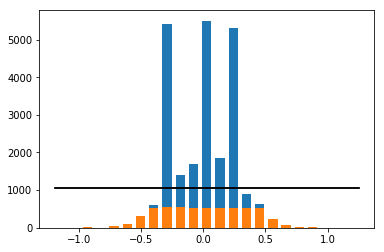

Size of data after removing unwanted values: (5634,) (5634,)


In [5]:
num_bins = 23
avg_samples_per_bin = len(angles)/num_bins
hist, bins = np.histogram(angles, num_bins)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(angles), np.max(angles)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')
#set keep probability for data from steering angles with more than half the average samples per angle
keep_probs = []
target = avg_samples_per_bin * .5
for i in range(num_bins):
    if hist[i] < target:
        keep_probs.append(1.)
    else:
        keep_probs.append(1./(hist[i]/target))
remove_list = []
for i in range(len(angles)):
    for j in range(num_bins):
        if angles[i] > bins[j] and angles[i] <= bins[j+1]:
            # delete from X and y with probability 1 - keep_probs[j]
            if np.random.rand() > keep_probs[j]:
                remove_list.append(i)
image_paths = np.delete(image_paths, remove_list, axis=0)
angles = np.delete(angles, remove_list)

# print histogram to show the new distribution of steering angles
hist, bins = np.histogram(angles, num_bins)
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(angles), np.max(angles)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')
plt.show()

print('Size of data after removing unwanted values:', image_paths.shape, angles.shape)

## Keras model with Nvidia CNN

The model used below is the suggested Nvidia architecture.

- Input size is 3@66x200
- Convolutional Layer: 36 feature maps 5x5 Kernal - Output:36@14x47
- Convolutional Layer: 48 feature maps 5x5 Kernal - Output:48@5x22
- Convolutional Layer: 64 feature maps 3x3 Kernal - Output:64@3x20
- Convolutional Layer: 64 feature maps 3x3 Kernal - Output:64@1x18
- Flatten
- Fully Connected Layer x4

The generator is used to create more data for the training and validation sets. Since the data creation and shuffle provides enough changes we use the initial data set for both training and validation sets.

In [7]:
model = Sequential()
model.add(Lambda(lambda x: (x / 127.5) - 1.0, input_shape=(66,200,3)))
##Nvidia Model
model.add(Convolution2D(24,5,5,subsample=(2,2),activation="relu"))
model.add(Convolution2D(36,5,5,subsample=(2,2),activation="relu"))
model.add(Convolution2D(48,5,5,subsample=(2,2),activation="relu"))
model.add(Convolution2D(64,3,3,activation="relu"))
model.add(Convolution2D(64,3,3,activation="relu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

train_gen = generate_training_data(image_paths, angles, batch_size=64)
val_gen = generate_training_data(image_paths, angles, batch_size=64)

history = model.fit_generator(train_gen, validation_data=val_gen, nb_val_samples=2560, samples_per_epoch=23040, 
                                  nb_epoch=5, verbose=2, callbacks=[checkpoint])

model.save('model.h5')
print("done")

Epoch 1/5
154s - loss: 0.0331 - val_loss: 0.0242
Epoch 2/5
44s - loss: 0.0205 - val_loss: 0.0187
Epoch 3/5
93s - loss: 0.0158 - val_loss: 0.0129
Epoch 4/5
95s - loss: 0.0106 - val_loss: 0.0073
Epoch 5/5
53s - loss: 0.0067 - val_loss: 0.0050
done
